In [1]:
import sys
from os.path import join, exists, abspath
from os import getcwd, makedirs
from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colormaps, cm, colors
import scipy
import h5py
import seaborn as sns

from tqdm import tqdm
import pickle

In [2]:
import warnings

In [3]:
from sklearn.preprocessing import StandardScaler

# Z-Score 정규화
scaler = StandardScaler()

In [4]:
import nibabel as nb
from nilearn import plotting
from nipype.interfaces import fsl

In [5]:
from nilearn.plotting import plot_design_matrix, plot_surf_stat_map
from nilearn.glm.first_level import spm_hrf, glover_hrf
from scipy import signal
import statsmodels.api as sm
from nilearn.glm.first_level import make_first_level_design_matrix, FirstLevelModel

In [6]:
from nilearn.datasets import load_fsaverage
from nilearn.surface import SurfaceImage

---

In [7]:
import warnings

In [8]:
dir_git = 'D:/mobaxterm/sungbeenpark/github'
dir_result = join(dir_git,'diedrichsenlab/SeqSpatialSupp_fMRI/results')
exists(dir_result)

True

In [9]:
path_module = abspath(join(dir_git,'nitools'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import nitools as nt

added the path, D:\mobaxterm\sungbeenpark\github\nitools


In [10]:
path_module = abspath(join(dir_git,'SUITPy'))
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import SUITPy as suit

added the path, D:\mobaxterm\sungbeenpark\github\SUITPy


In [11]:
path_module = abspath(dir_git)
if exists(path_module):
    print('added the path, %s'%path_module)
    if path_module not in sys.path:
        sys.path.append(path_module)

import surfAnalysisPy as surf

added the path, D:\mobaxterm\sungbeenpark\github


In [12]:
dir_data = join('F:/SeqSpatialSupp_fMRI')

In [13]:
dir_atlas = join(dir_git,'diedrichsenlab/atlas/fs_LR_32k')
underlay = join(dir_atlas,'fs_LR.32k.LR.sulc.dscalar.gii')
border = join(dir_git,'surfAnalysisPy/standard_mesh/fs_L/fs_LR.32k.L.border')

---

## Behavioural Data

### sessions
- S
- R

### Each session is consist of 8 runs with 68 trials (4 blocks, 17 trials for each block), additional run with long-ISI.
1. The starting trial states are randomly permuted.
2. 5s for each trial (preparation: 1s, movement: 3s, ISI: 1s)
3. Long resting period between blocks (17-, 34-, 57-, 64-th trial; ~16 seconds)
4. Each run takes about 7 minutes

### Properties
- seqID (0: 32451, 1:35124, 2:13254, 3:14523)
- seqType (0: Number cue, 1: Spatial visual cue)
- trialState (seqID, seqType)=0:(0,0), 1:(0,1), 2:(1,0), 3:(1,1), 4:(2,0), 5:(2,1), 6:(3,0), 7:(3,1)
- transitionState (1-64: interest, 65-68: non-interest; 1:(0,0)->(0,0))
- isError (0: success, 1: error)

In [14]:
# list_Seq = ['32451', '35124', '13254', '14523']
# list_Cue = ['Letter', 'Spatial']

In [15]:
dir_behav = join(dir_git,'diedrichsenlab/SeqSpatialSupp_fMRI/behav_data')
exists(dir_behav)

True

In [16]:
def load_behav(subj):
    fname = join(dir_behav,'ssh__%s.dat'%subj)
    df = pd.read_csv(fname, delimiter='\t')
    # print(df.columns.values)
    
    df = df.filter(items=['BN','TN','isError','points','startTimeReal','seqType','cueP',*['response%d'%d for d in range(5)],'MT','RT','complete','iti'])
    df.cueP = df.cueP.astype('str')
    df.rename(columns={'seqType':'idx_cue', 'cueP':'seq', 'startTimeReal':'onsettime'}, inplace=True)
    
    return df

In [17]:
subj = 'S01'
df = load_behav(subj)
df

,BN,TN,isError,points,onsettime,idx_cue,seq,response0,response1,response2,response3,response4,MT,RT,complete,iti
0,1,1,0,1,8030.013,1,35124,3,5,1,2,4,1680,566,0,1000
1,1,2,0,1,13030.012,1,14523,1,4,5,2,3,1720,382,0,1000
2,1,3,0,1,18030.027,0,14523,1,4,5,2,3,2056,438,0,1000
3,1,4,0,1,23030.014,0,35124,3,5,1,2,4,1528,478,0,1000
4,1,5,0,1,28030.000,1,32451,3,2,4,5,1,1308,408,0,1000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,8,64,0,1,368031.961,1,13254,1,3,2,5,4,1360,306,0,1000
540,8,65,0,1,373031.951,0,13254,1,3,2,5,4,1870,364,0,1000
541,8,66,0,1,378031.951,1,35124,3,5,1,2,4,1486,412,0,1000
542,8,67,0,1,383031.964,0,35124,3,5,1,2,4,1668,234,0,1000


---

## Create Design Matrix

In [18]:
def set_df_design(data, reg_name):
    df_design = pd.DataFrame(columns=['trial_type', 'onset', 'duration'])
    df_design['trial_type'] = data[reg_name]
    df_design['onset'] = (data['onsettime']+data['RT']+1000) * 0.001
    df_design['duration'] = [dur*0.001 if dur>0 else 3 for dur in data['MT']]
    return df_design

### 1. Trial States (GLM3):

idx: (sequence, cue) -> $idx = seq*2 + cue$
- i) 0: (0,0)
- ii) 1: (0,1)
- iii) 2: (1,0)
- iv) 3: (1,1)
- v) 4: (2,0)
- vi) 5: (2,1)
- vii) 6: (3,0)
- viii) 7: (3,1)

In [19]:
def set_glm3(subj=None):
    df = load_behav(subj)
    df_tmp = df.filter(items=['BN','TN','iti','onsettime','idx_cue','seq','isError','RT','MT'])
    ## Interest
    df_tmp['idx_seq'] = [
        0 if row=='32451' else (
            1 if row=='35124' else (2 if row=='13254' else (3 if row=='14523' else 'invalid'))
        ) for row in df_tmp.seq
    ]
    df_tmp['Trial_State'] = ['(%d,%d)'%(idx_s,idx_c) for idx_s, idx_c in zip(df_tmp.idx_seq, df_tmp.idx_cue)]
    
    ## Non-interest
    df_tmp.loc[df_tmp.isError==1, 'Trial_State'] = 'N'
    
    return df_tmp

In [20]:
df_tmp = set_glm3(subj)
df_tmp

,BN,TN,iti,onsettime,idx_cue,seq,isError,RT,MT,idx_seq,Trial_State
0,1,1,1000,8030.013,1,35124,0,566,1680,1,"(1,1)"
1,1,2,1000,13030.012,1,14523,0,382,1720,3,"(3,1)"
2,1,3,1000,18030.027,0,14523,0,438,2056,3,"(3,0)"
3,1,4,1000,23030.014,0,35124,0,478,1528,1,"(1,0)"
4,1,5,1000,28030.000,1,32451,0,408,1308,0,"(0,1)"
...,...,...,...,...,...,...,...,...,...,...,...
539,8,64,1000,368031.961,1,13254,0,306,1360,2,"(2,1)"
540,8,65,1000,373031.951,0,13254,0,364,1870,2,"(2,0)"
541,8,66,1000,378031.951,1,35124,0,412,1486,1,"(1,1)"
542,8,67,1000,383031.964,0,35124,0,234,1668,1,"(1,0)"


In [21]:
run = 1
df_design = set_df_design(data=df_tmp[df_tmp.BN==run], reg_name='Trial_State')
df_design

,trial_type,onset,duration
0,"(1,1)",9.596013,1.680
1,"(3,1)",14.412012,1.720
2,"(3,0)",19.468027,2.056
3,"(1,0)",24.508014,1.528
4,"(0,1)",29.438000,1.308
...,...,...,...
63,"(0,1)",369.476010,1.944
64,"(3,1)",374.582001,2.448
65,"(3,1)",379.610016,2.060
66,"(1,1)",384.444018,2.316


### 2. Repetition (GLM2)

|  | trial $_{t-1}$ | trial $_{t}$ |
|---------|---------|---------|
| Both-Rep| $(s,c)$ | $(s,c)$ |
| Cue-Rep | $(s,\neg c)$ | $(s,c)$ |
| Seq-Rep | $(\neg s,c)$ | $(s,c)$ |
| NRep    | $(\neg s,\neg c)$ | $(s,c)$ |

$ c=0: Letter $, $ c=1: Spatial $

$ s=0: 32451 $, $ s=1: 35124 $, $s=2: 13254 $, $ s=3: 14523$

In [22]:
# list_reg = [
#     'MotorOnly-L','MotorOnly-S','CueOnly-L','CueOnly-S','BothRep-L',
#     'BothRep-S','NonRep-L','NonRep-S','Non-Interest'
# ]

In [23]:
def set_glm2(subj=None):
    df = load_behav(subj)
    df_tmp = df.filter(items=['BN','TN','iti','onsettime','idx_cue','seq','isError','RT','MT'])

    list_col = ['iti','idx_cue','seq','isError','RT','MT']
    ## 이전 trial의 sequence, cue, and validation 불러오기
    for col in list_col:
        col_pre = '%s-1'%col
        df_tmp[col_pre] = df[col].shift(1)
    
    ## NaN행 제거
    df_tmp = df_tmp[(df_tmp.TN>1)&(df_tmp.TN<=68)]
    
    ## 자료형 정리
    for col in list_col:
        col_pre = '%s-1'%col
        if col!='seq':
            df_tmp[col_pre] = df_tmp[col_pre].astype(int)
    
    ## trials 제거
    # df_tmp = df_tmp[(df_tmp.isError==0)&(df_tmp['isError-1']==0)]
    # df_tmp = df_tmp[df_tmp['iti-1']<=1000]
    
    ## default condition = N_Rep
    df_tmp['Repetition'] = 'N_Rep'
    
    ## other conditions
    df_tmp.loc[(df_tmp.idx_cue==df_tmp['idx_cue-1'])&(df_tmp.seq==df_tmp['seq-1']),'Repetition'] = 'Both_Rep'
    df_tmp.loc[(df_tmp.idx_cue==df_tmp['idx_cue-1'])&(df_tmp.seq!=df_tmp['seq-1']),'Repetition'] = 'Cue_Rep'
    df_tmp.loc[(df_tmp.idx_cue!=df_tmp['idx_cue-1'])&(df_tmp.seq==df_tmp['seq-1']),'Repetition'] = 'Seq_Rep'
    for row, _ in df_tmp.iterrows():
        val = df_tmp.loc[row,'Repetition']
        cue = df_tmp.loc[row,'idx_cue'].copy()
        cue = 'Letter' if cue==0 else 'Spatial'
        if val != 'NRep':
            df_tmp.loc[row,'Repetition'] = '%s_%s'%(val,cue)
    
    ## Non-Interest : error trials
    df_tmp.loc[(df_tmp.isError==1)|(df_tmp['isError-1']==1),'Repetition'] = 'N_IN'
    
    return df_tmp

In [24]:
df_tmp = set_glm2(subj)
df_tmp

,BN,TN,iti,onsettime,idx_cue,seq,isError,RT,MT,iti-1,idx_cue-1,seq-1,isError-1,RT-1,MT-1,Repetition
1,1,2,1000,13030.012,1,14523,0,382,1720,1000,1,35124,0,566,1680,Cue_Rep_Spatial
2,1,3,1000,18030.027,0,14523,0,438,2056,1000,1,14523,0,382,1720,Seq_Rep_Letter
3,1,4,1000,23030.014,0,35124,0,478,1528,1000,0,14523,0,438,2056,Cue_Rep_Letter
4,1,5,1000,28030.000,1,32451,0,408,1308,1000,0,35124,0,478,1528,N_Rep_Spatial
5,1,6,1000,33030.005,0,35124,0,446,1776,1000,1,32451,0,408,1308,N_Rep_Letter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,8,64,1000,368031.961,1,13254,0,306,1360,1000,1,35124,0,316,1736,Cue_Rep_Spatial
540,8,65,1000,373031.951,0,13254,0,364,1870,1000,1,13254,0,306,1360,Seq_Rep_Letter
541,8,66,1000,378031.951,1,35124,0,412,1486,1000,0,13254,0,364,1870,N_Rep_Spatial
542,8,67,1000,383031.964,0,35124,0,234,1668,1000,1,35124,0,412,1486,Seq_Rep_Letter


In [25]:
run = 1
df_design = set_df_design(data=df_tmp[df_tmp.BN==run], reg_name='Repetition')
df_design

,trial_type,onset,duration
1,Cue_Rep_Spatial,14.412012,1.720
2,Seq_Rep_Letter,19.468027,2.056
3,Cue_Rep_Letter,24.508014,1.528
4,N_Rep_Spatial,29.438000,1.308
5,N_Rep_Letter,34.476005,1.776
...,...,...,...
63,N_IN,369.476010,1.944
64,Cue_Rep_Spatial,374.582001,2.448
65,Both_Rep_Spatial,379.610016,2.060
66,Cue_Rep_Spatial,384.444018,2.316


---

## Design Matrix

In [26]:
t_r = 1
nscans = 410
nruns = 8

### HRF

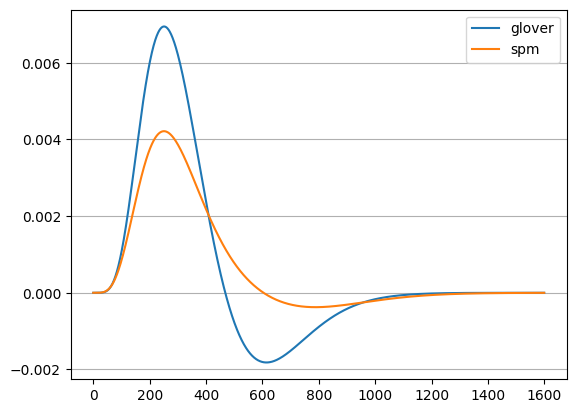

In [27]:
y = glover_hrf(t_r=1)
x = np.arange(len(y))
plt.plot(x,y,label='glover')

y = spm_hrf(t_r=1)
x = np.arange(len(y))
plt.plot(x,y,label='spm')

plt.grid(axis='y')
plt.legend()

In [28]:
frame_times = np.arange(nscans) * t_r

<Axes: >

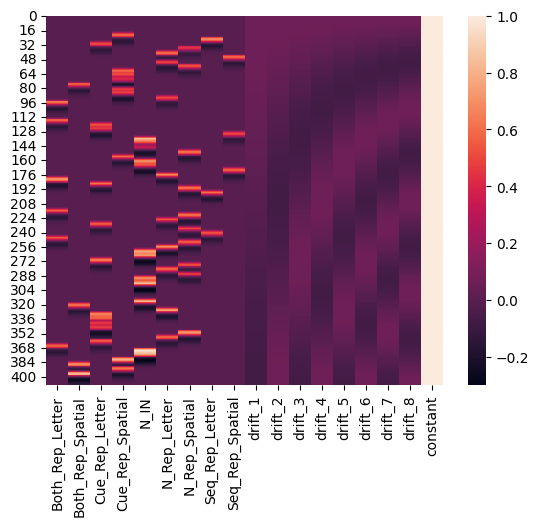

In [29]:
X1 = make_first_level_design_matrix(
    frame_times=frame_times,
    events=df_design,
    drift_model="cosine", high_pass=0.01,
    # add_regs=motion,
    # add_reg_names=["tx", "ty", "tz", "rx", "ry", "rz"],
    hrf_model="glover",
    # hrf_model="glover + derivative",
)
sns.heatmap(X1)

In [30]:
# list_contrast = sorted(X1.columns[:9])

## glm2
list_contrast = [
    'Both_Rep_Letter', 'Both_Rep_Spatial',
    'Cue_Rep_Letter', 'Cue_Rep_Spatial',
    'Seq_Rep_Letter', 'Seq_Rep_Spatial',
    'N_Rep_Letter', 'N_Rep_Spatial',
    # 'N_IN'
]

## glm3
list_contrast = ['(%1d,%1d)'%(ii//2,ii%2) for ii in range(8)]

list_contrast

['(0,0)', '(0,1)', '(1,0)', '(1,1)', '(2,0)', '(2,1)', '(3,0)', '(3,1)']

<Axes: >

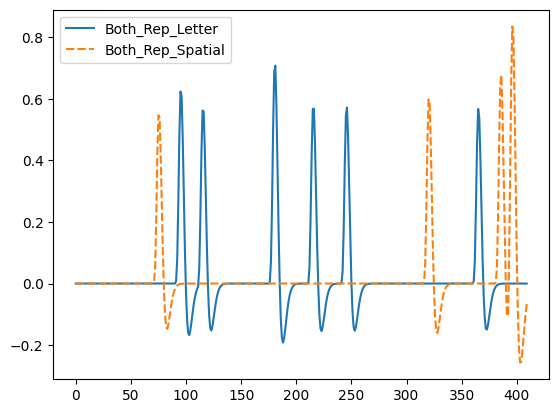

In [31]:
sns.lineplot(data=X1[X1.columns[:2]])

In [32]:
model = FirstLevelModel(
    t_r=t_r,
    smoothing_fwhm=4, signal_scaling=0,
    noise_model="ar1",
    subject_label=subj,
    minimize_memory=False,
    verbose=1
)
model

FirstLevelModel(minimize_memory=False, smoothing_fwhm=4, subject_label='S01',
                t_r=1, verbose=1)

In [33]:
# dir_glm = join(dir_data,'glm_2.onset0')
# fname = join(dir_glm,subj,'SPM.mat')

# feature = h5py.File(fname)
# # feature = scipy.io.loadmat(fname)
# print(feature.keys())

# data = feature['SPM']
# # data.keys()

# print(data['xX'].keys())
# mat_X = data['xX']['X'][:].T
# print(mat_X.shape)

# ## interest
# idx_col = np.concatenate(data['xX']['iC'][:]).astype(int) - 1
# ## non-insterest (baseline)
# # idx_col = np.concatenate(data['xX']['iB'][:]).astype(int)

# mat_X = mat_X[:,idx_col]
# print(mat_X.shape)

In [34]:
# sns.heatmap(mat_X[:410,:8], cmap=cm.viridis)

---

## Load $Y_{raw}$

In [35]:
dir_preproc = join(dir_data,'imaging_data')
exists(dir_preproc)

True

In [36]:
run = 1
fname = join(dir_preproc,subj,'u%s_run_%02d.nii'%(subj,run))
print(exists(fname))

img = nb.load(fname)
img.shape

True


(116, 116, 57, 410)

In [37]:
model.fit(
    run_imgs=img,
    # events=df_design,
    design_matrices=X1
)

[FirstLevelModel.fit] Computing run 1 out of 1 runs (go take a coffee, a big one).
[FirstLevelModel.fit] Performing mask computation.
[FirstLevelModel.fit] Masking took 20 seconds.
[FirstLevelModel.fit] Performing GLM computation.
[FirstLevelModel.fit] GLM took 8 seconds.
[FirstLevelModel.fit] Computation of 1 runs done in 30 seconds.


FirstLevelModel(fir_delays=[0], memory=Memory(location=None),
                minimize_memory=False, smoothing_fwhm=4, subject_label='S01',
                t_r=1, verbose=1)

In [38]:
ax, ay, az = 80, 40, 30

t = np.arange(410)

df = pd.DataFrame()
## y_raw
y = img.get_fdata()[ax,ay,az,:]
df['y_raw']=scaler.fit_transform(y.reshape(-1,1)).flatten()
# df['y_raw']=y
## y_hat
y = model.predicted[0].get_fdata()[ax,ay,az,:]
df['y_hat']=y
# df['y_hat']=scaler.fit_transform(y.reshape(-1,1)).flatten()
## y_res
y = model.residuals[0].get_fdata()[ax,ay,az,:]
# df['y_res']=scaler.fit_transform(y.reshape(-1,1)).flatten()
df['y_res']=y
df

,y_raw,y_hat,y_res
0,0.920725,0.782730,1.415179
1,1.535659,0.547957,1.191187
2,1.396803,0.548036,0.661438
3,1.370354,0.548147,0.947977
4,1.436476,0.548292,0.290739
...,...,...,...
405,-0.163676,-0.372986,-0.031670
406,0.649624,-0.374238,-0.469215
407,0.887664,-0.375453,0.697187
408,-0.077718,-0.376464,-0.239252


<Axes: >

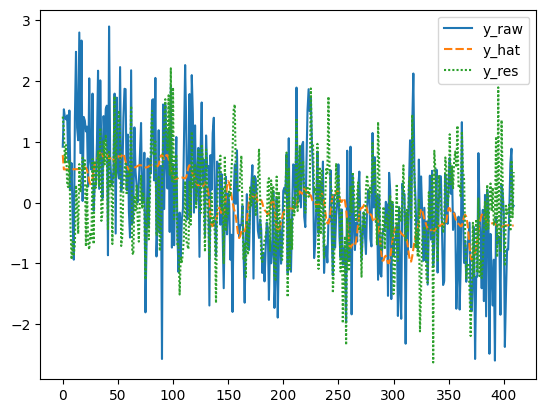

In [39]:
sns.lineplot(data=df)

---

## Contrast

In [40]:
def make_loaclizer_contrasts(design_matrix, glm=None):
    ## interest regressors
    filtered_col = [col for col in design_matrix.columns if 'drift' not in col and 'constant' not in col]
    ## identity matrix
    contrast_matrix = np.eye(len(design_matrix.columns)).astype(int)
    
    ## canonical contrasts (condition vectors = each row of the identity matrix)
    dict_contrast = {
        column: contrast_matrix[i]
        for i, column in enumerate(filtered_col)
    }

    if glm==2:
        dict_contrast['wRS-L'] = (
            dict_contrast['Both_Rep_Letter'] - dict_contrast['Cue_Rep_Letter']
        )
        dict_contrast['wRS-S'] = (
            dict_contrast['Both_Rep_Spatial'] - dict_contrast['Cue_Rep_Spatial']
        )
        dict_contrast['acRS-L'] = (
            dict_contrast['Seq_Rep_Letter'] - dict_contrast['N_Rep_Letter']
        )
        dict_contrast['acRS-S'] = (
            dict_contrast['Seq_Rep_Spatial'] - dict_contrast['N_Rep_Spatial']
        )
        dict_contrast['Letter'] = (
            dict_contrast['Both_Rep_Letter'] + dict_contrast['Seq_Rep_Letter'] +
            dict_contrast['Cue_Rep_Letter'] + dict_contrast['N_Rep_Letter']
        )
        dict_contrast['Spatial'] = (
            dict_contrast['Both_Rep_Spatial'] + dict_contrast['Seq_Rep_Spatial'] +
            dict_contrast['Cue_Rep_Spatial'] + dict_contrast['N_Rep_Spatial']
        )
        
    return dict_contrast

In [41]:
glm = 3
dict_contrast = make_loaclizer_contrasts(X1, glm=glm)

list_contrast = list(dict_contrast.keys())
print(list_contrast)
if glm==2:
    list_contrast = list_contrast[-6:]
print(list_contrast)

['Both_Rep_Letter', 'Both_Rep_Spatial', 'Cue_Rep_Letter', 'Cue_Rep_Spatial', 'N_IN', 'N_Rep_Letter', 'N_Rep_Spatial', 'Seq_Rep_Letter', 'Seq_Rep_Spatial']
['Both_Rep_Letter', 'Both_Rep_Spatial', 'Cue_Rep_Letter', 'Cue_Rep_Spatial', 'N_IN', 'N_Rep_Letter', 'N_Rep_Spatial', 'Seq_Rep_Letter', 'Seq_Rep_Spatial']


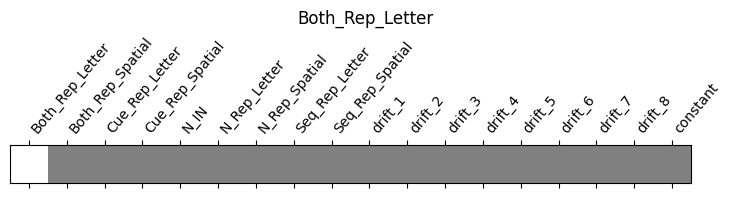

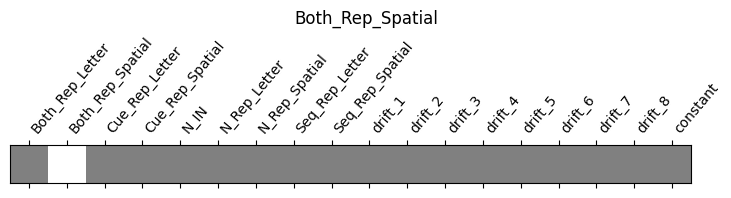

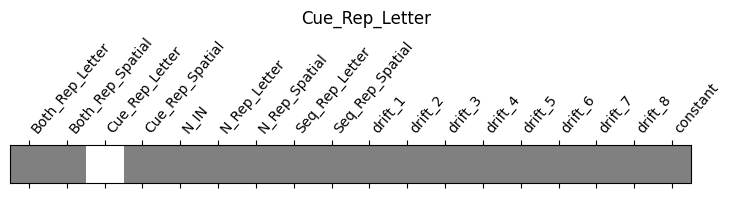

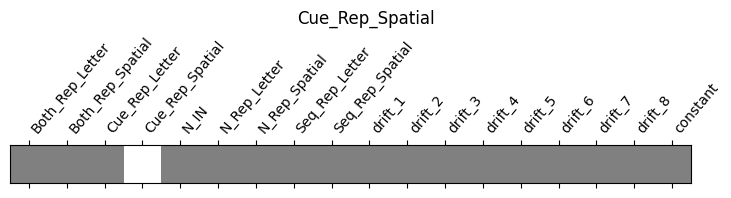

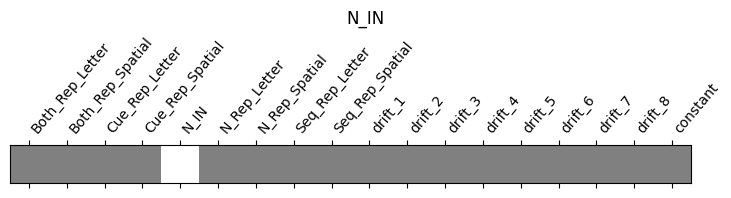

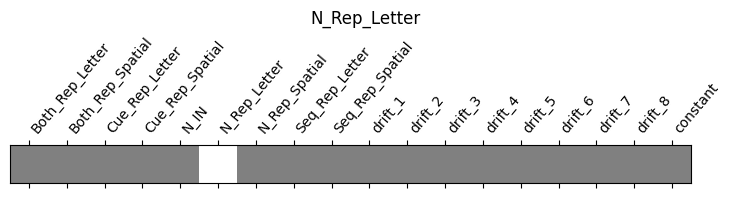

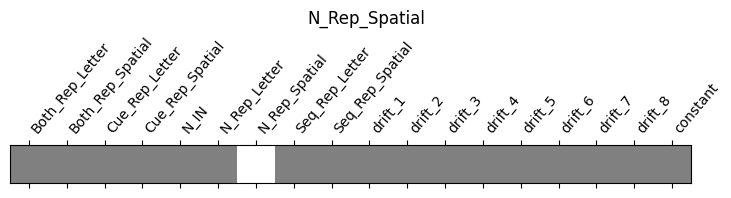

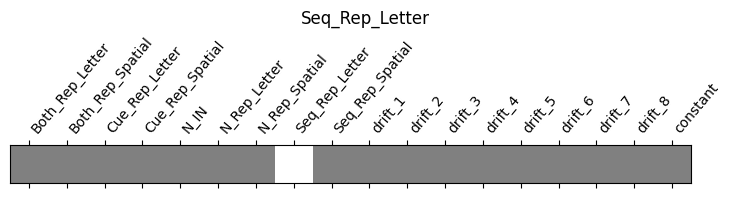

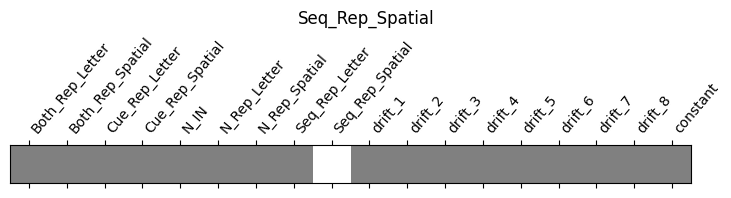

In [42]:
for key, contrast in dict_contrast.items():
    plotting.plot_contrast_matrix(contrast, X1)
    plt.suptitle(key)
    # z_map = model.compute_contrast(contrast, output_type='z_score')
    # t_map = model.compute_contrast(contrast, output_type='stat')
    # beta_map = model.compute_contrast(contrast, output_type='effect_size')

In [43]:
# pval = 0.05
# thresh = scipy.stats.t.isf(0.5*pval, df=8)
# plotting.view_img(z_map, threshold=thresh)

---

## vol2surf

In [44]:
dir_surf = join(dir_data,'surfaceWB')
exists(dir_surf)

True

In [45]:
def func_vol2surf(volume, pial, white, depths=[0,0.2,0.4,0.6,0.8,1.0]):
    if isinstance(pial, str):
        img_pial = nb.load(pial)
    else:
        img_pial = pial
    if isinstance(white, str):
        img_white = nb.load(white)
    else:
        img_white = white
        
    c1 = img_white.darrays[0].data
    faces = img_white.darrays[1].data
    numVerts = c1.shape[0]
    
    c2 = img_pial.darrays[0].data
    
    numPoints = len(depths)
    
    # Get the indices for all the points being sampled
    indices = np.zeros((numPoints,numVerts,3), dtype=int)

    if isinstance(volume, str):
        img = nb.load(volume)
        data = img.get_fdata()
    elif isinstance(volume, nb.nifti1.Nifti1Image):
        img = volume
        data = img.get_fdata()

    ndim = data.ndim
    if ndim==3:
        data_mapped = np.zeros((numPoints, numVerts))
    elif ndim==4:
        nTR = data.shape[-1]
        data_mapped = np.zeros((nTR, numPoints, numVerts))
    
    for i in range(numPoints):
        c = (1-depths[i])*c1.T+depths[i]*c2.T
        ijk = nt.coords_to_voxelidxs(c,img)
        indices[i] = ijk.T
    
    for p in range(numPoints):
        if ndim==3:
            data_mapped[p,:] = data[indices[p,:,0],indices[p,:,1],indices[p,:,2]]
            outside = (indices[p,:,:]<0).any(axis=1) # These are vertices outside the volume
            data_mapped[p,:][outside] = np.nan
        elif ndim==4:
            for t in range(nTR):
                data_mapped[t,p,:] = data[:,:,:,t][indices[p,:,0],indices[p,:,1],indices[p,:,2]]
                outside = (indices[p,:,:]<0).any(axis=1) # These are vertices outside the volume
                data_mapped[t,p,:][outside] = np.nan
                
    if ndim==3:
        return np.nanmean(data_mapped,axis=0)
    elif ndim==4:
        return np.nanmean(data_mapped,axis=1)

In [46]:
pval = 0.05
thresh = scipy.stats.t.isf(0.5*pval, df=8)

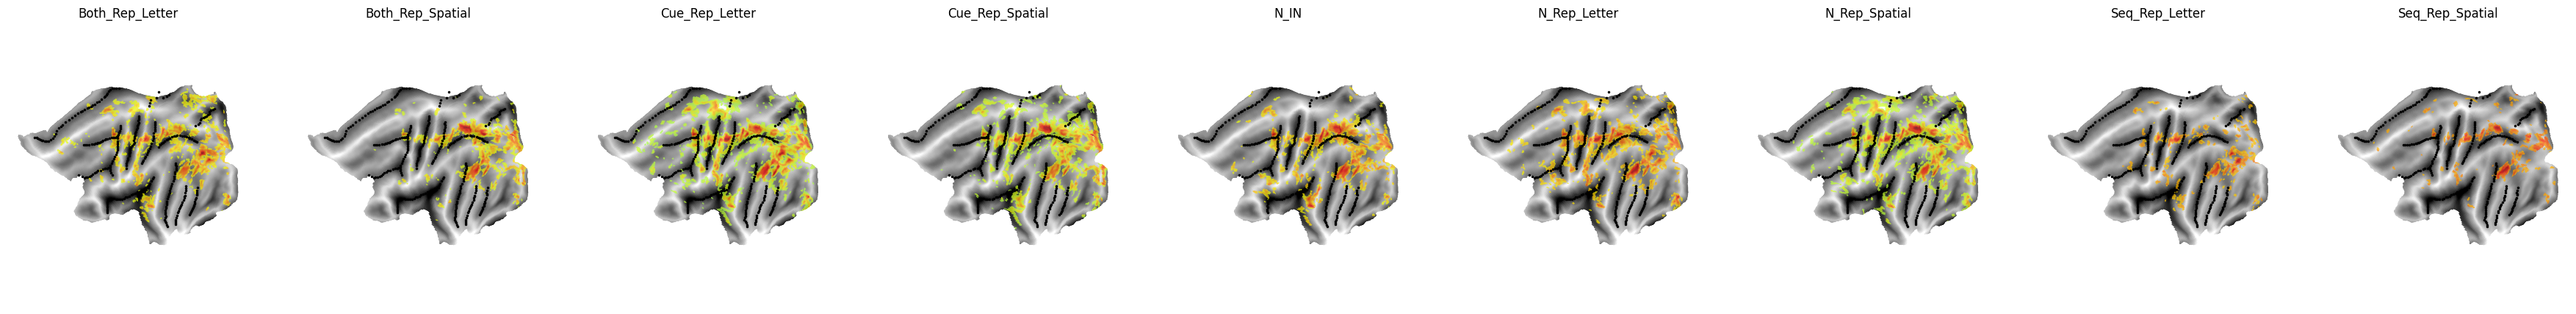

In [47]:
ncols = len(list_contrast)
fig, axs = plt.subplots(ncols=ncols, figsize=(5*ncols,5))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for ii, contrast in enumerate(list_contrast):
        ax = axs[ii]
        plt.sca(ax)
        vec_contrast = dict_contrast[contrast]
        z_map = model.compute_contrast(vec_contrast)
        img_surf = func_vol2surf(
            volume=z_map,
            pial=join(dir_surf,subj,'%s.L.pial.32k.surf.gii'%subj),
            white=join(dir_surf,subj,'%s.L.white.32k.surf.gii'%subj),
        )
        surf.plot.plotmap(
            data=img_surf,
            surf='fs32k_L',
            underlay=underlay, alpha=0.7, cmap=cm.jet,
            borders=border, bordercolor='black', bordersize=3,
            overlay_type='func', render='matplotlib',
            threshold=thresh
        )
        ax.set_title(contrast)

---

## Group

In [48]:
# list_ss = ['S']
list_ss = ['S', 'R']

In [49]:
# list_nn = ['01', '02']

tmp = [1,2,3,5,6,8,9,10,11,12,13,14]
list_nn = ['%02d'%i for i in tmp]
list_nn

['01', '02', '03', '05', '06', '08', '09', '10', '11', '12', '13', '14']

In [50]:
# list_run = [1, 2, 3]

list_run = [rr+1 for rr in range(8)]
list_run

[1, 2, 3, 4, 5, 6, 7, 8]

In [51]:
t_r = 1
nscans = 410
frame_times = np.arange(nscans)*t_r
frame_times

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [52]:
glm = 3
dir_output = join(dir_surf,'python/glm%d'%glm)
if not exists(dir_output):
    makedirs(dir_output, exist_ok=True)

In [53]:
# output_type = 'z_score' # z_map
output_type = 'effect_size' # beta

In [54]:
# (nsubj, nrun, ncontrast, nvoxel)
# data_surf = np.zeros((len(list_ss)*len(list_nn),len(list_run),len(list_contrast),32492))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for ss, sess in enumerate(list_ss):
        for nn, subj_id in enumerate(tqdm(list_nn)):
            s_id = 'S'+subj_id
            # idx = ss*len(list_nn)+nn
            subj = sess+subj_id

            if glm == 2:
                df = set_glm2(subj)
                reg_name = 'Repetition'
            elif glm == 3:
                df = set_glm3(subj)
                reg_name = 'Trial_State'
            
            for rr, run in enumerate(list_run):
                ## set GLM
                df_design = set_df_design(data=df[df.BN==run], reg_name=reg_name)
                X1 = make_first_level_design_matrix(
                    frame_times=frame_times,
                    events=df_design,
                    drift_model="polynomial",
                    drift_order=4,
                    # add_regs=motion,
                    # add_reg_names=["tx", "ty", "tz", "rx", "ry", "rz"],
                    hrf_model="spm",
                )

                ## initialize list_contrast
                dict_contrast = make_loaclizer_contrasts(X1, glm=glm)
                list_contrast = list(dict_contrast.keys())
                if glm==2:
                    list_contrast = list_contrast[-6:]
                    
                model = FirstLevelModel(
                    t_r=t_r,
                    hrf_model='spm',
                    drift_model='polynomial', drift_order=4,
                    min_onset=0,
                    smoothing_fwhm=4, signal_scaling=0,
                    subject_label=subj,
                    minimize_memory=False
                )
                ## load Y_raw
                fname = join(dir_preproc,subj,'u%s_run_%02d.nii'%(subj,run))
                img = nb.load(fname)
                model.fit(run_imgs=img, design_matrices=[X1])

                ## residual
                img_y_res = model.residuals[0]
                # fname = join(dir_output,'%s.r%02d.glm%d.Y_res.nii'%(subj,run,glm))
                # nb.save(img_y_res, fname)
                y_res = func_vol2surf(
                    volume=img_y_res,
                    pial=join(dir_surf,s_id,'%s.L.pial.32k.surf.gii'%s_id),
                    white=join(dir_surf,s_id,'%s.L.white.32k.surf.gii'%s_id),
                )
                fname = join(dir_output,'%s.r%02d.glm%d.Y_res.surf.pkl'%(subj,run,glm))
                with open(fname, "wb") as f:
                    pickle.dump(y_res, f)
    
                ## contrast
                for cc, contrast in enumerate(list_contrast):
                    fname = join(dir_output,'%s.r%02d.glm%d.%s.%s.surf.pkl'%(subj,run,glm,contrast,output_type))
                    if exists(fname):
                        continue
                    ## initialize
                    data_mapped = np.zeros(32492)
                    vec_contrast = dict_contrast[contrast]
                    # z_map = model.compute_contrast(vec_contrast)
                    beta_map = model.compute_contrast(vec_contrast, output_type=output_type)
                    ## vol2surf
                    data_mapped = func_vol2surf(
                        volume=beta_map,
                        pial=join(dir_surf,s_id,'%s.L.pial.32k.surf.gii'%s_id),
                        white=join(dir_surf,s_id,'%s.L.white.32k.surf.gii'%s_id),
                    )
                    with open(fname, "wb") as f:
                        pickle.dump(data_mapped, f)

100%|██████████| 12/12 [1:35:14<00:00, 476.25s/it]


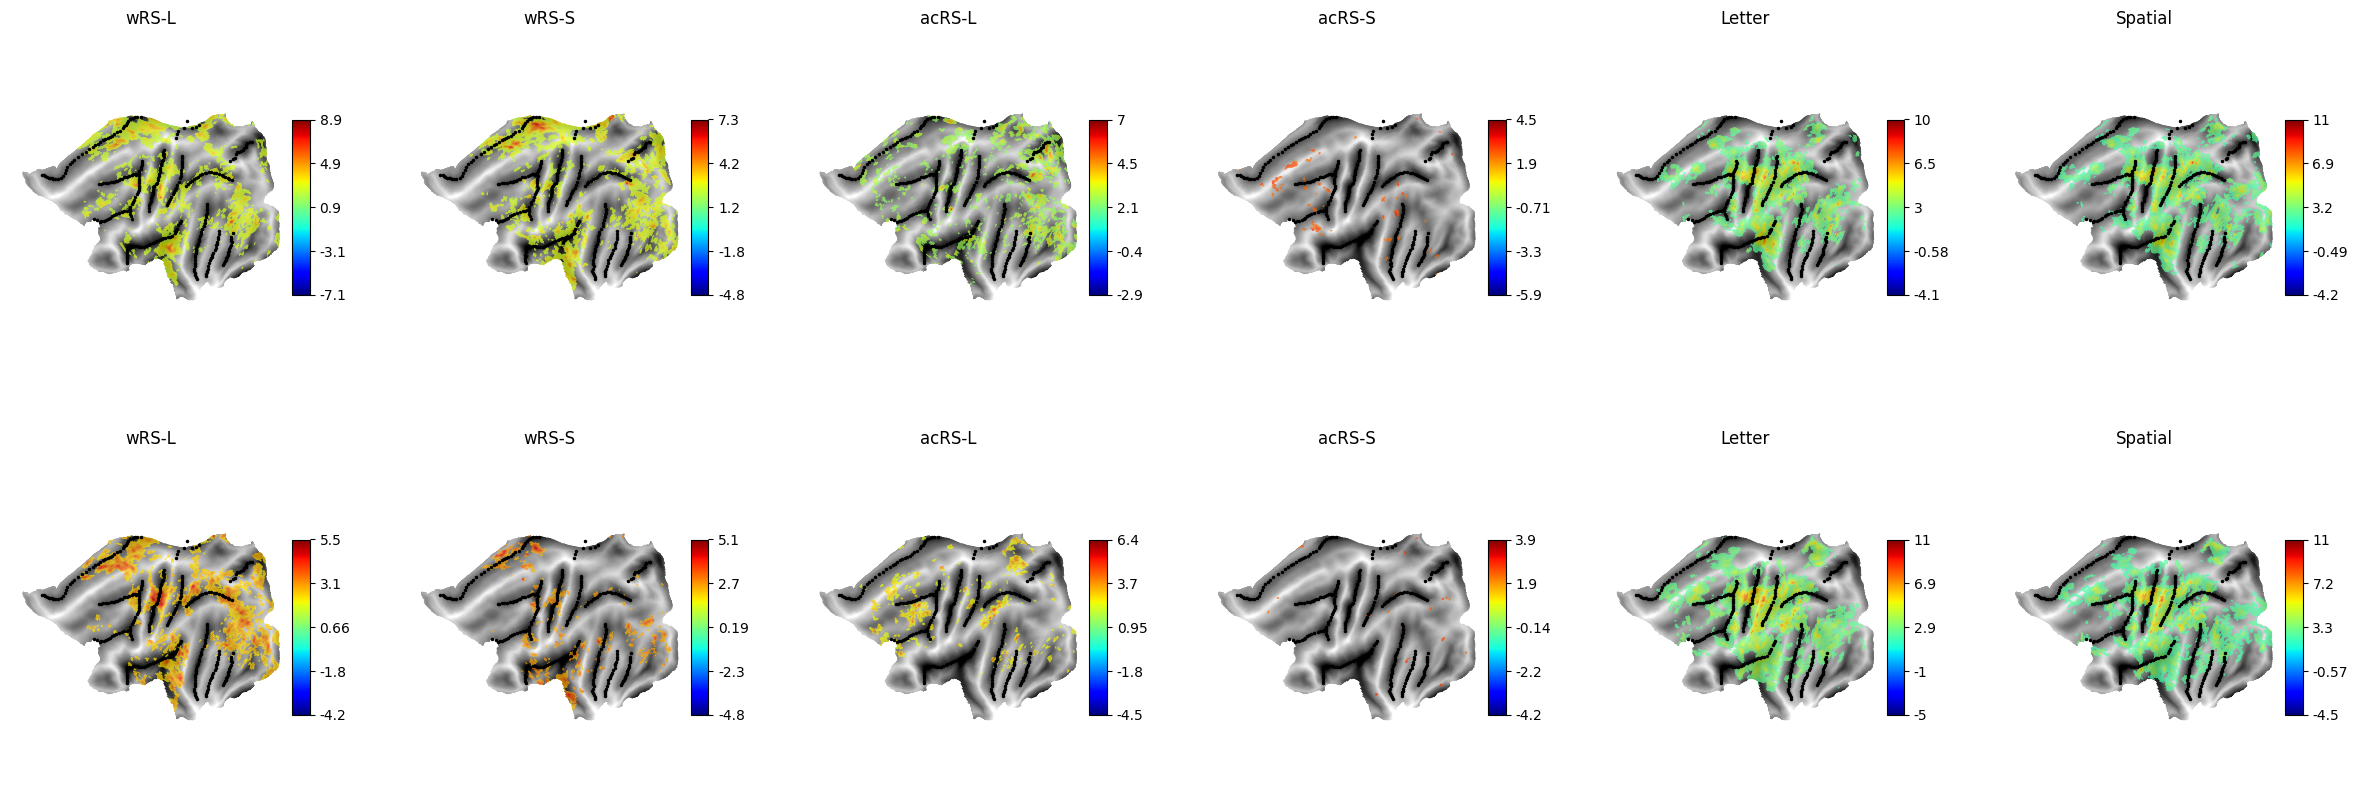

In [40]:
nrows = len(list_ss)
ncols = len(list_contrast)
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 5*nrows))

# 저장된 pickle 파일 불러오기
glm = 2

if glm==2:
    list_contrast = ['wRS-L', 'wRS-S', 'acRS-L', 'acRS-S', 'Letter', 'Spatial']
elif glm==3:
    list_contrast = ['(0,0)', '(0,1)', '(1,0)', '(1,1)', '(2,0)', '(2,1)', '(3,0)', '(3,1)']

output_type = 'effect_size'
alpha = 0.05
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for ii, ss in enumerate(list_ss):
        for jj, contrast in enumerate(list_contrast):
            ax = axs[ii,jj]
            plt.sca(ax)
            
            data_surf = []
            for nn in list_nn:
                subj = ss+nn
                tmp = []
                for run in list_run:
                    fname = join(dir_output,'%s.r%02d.glm%d.%s.%s.surf.pkl'%(subj,run,glm,contrast,output_type))
                    with open(fname, "rb") as file:  # "rb"는 읽기 모드와 바이너리 모드를 의미
                        tmp.append(pickle.load(file))
                data_surf.append(np.nanmean(tmp, axis=0))
            ## one-sample t-test
            res = scipy.stats.ttest_1samp(data_surf, popmean=0, alternative='two-sided', axis=0)
            tval = res.statistic
            pval = res.pvalue
            data_surf = np.nanmean(data_surf, axis=0)
            surf.plot.plotmap(
                data=tval,
                surf='fs32k_L',
                underlay=underlay, alpha=0.7, cmap=cm.jet, colorbar=True,
                borders=border, bordercolor='black', bordersize=3,
                overlay_type='func', render='matplotlib',
                threshold=scipy.stats.t.isf(0.5*alpha, df=res.df[0])
            )
            ax.set_title(contrast)